In [15]:
%load_ext autoreload
%autoreload 2
    
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
from models.diffusion import StableDiffusion
import torch
from torchvision import transforms
from transformers import CLIPTokenizer
from PIL import Image
from utils.model_converter import load_weights_from_ckpt
from torch.ao.quantization import QConfig, HistogramObserver, MinMaxObserver


prompt = "A dog is sitting, looking out the window"
uncond_prompt = ""  # Also known as negative prompt
do_cfg = True
cfg_scale = 7.5  # min: 1, max: 14

## IMAGE TO IMAGE

# Comment to disable image to image
input_image = None
image_path = "./images/dog.jpg"
input_image = Image.open(image_path).convert('RGB')

# Higher values means more noise will be added to the input image, so the result will further from the input image.
# Lower values means less noise is added to the input image, so output will be closer to the input image.
strength = 0.1

## SAMPLER
num_inference_steps = 50
seed = 42
model = StableDiffusion(model_type='txt2img')
loaded_state_dict = load_weights_from_ckpt('./weights/model/v1-5-pruned-emaonly.ckpt', device='cpu')
model.vae.load_state_dict(loaded_state_dict['vae'], strict=True)
model.unet.load_state_dict(loaded_state_dict['unet'], strict=True)
model.cond_encoder.load_state_dict(loaded_state_dict['cond_encoder'], strict=True)

tokenizer = CLIPTokenizer('./weights/tokenizer/tokenizer_vocab.json', merges_file='./weights/tokenizer/tokenizer_merges.txt')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
%load_ext autoreload
%autoreload 2
output_image = model.generate(
    input_image=input_image,
    img_size=(512, 512),
     prompt=prompt,
     uncond_prompt=uncond_prompt,
     do_cfg=do_cfg,
     cfg_scale=cfg_scale,
     device='mps',
     strength=0.8,
     inference_steps=num_inference_steps,
     sampler='ddpm',
     use_cosine_schedule=False,
     seed=None,
     tokenizer=tokenizer
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|█████████████████████████████████████████████████████| 40/40 [01:09<00:00,  1.73s/it]


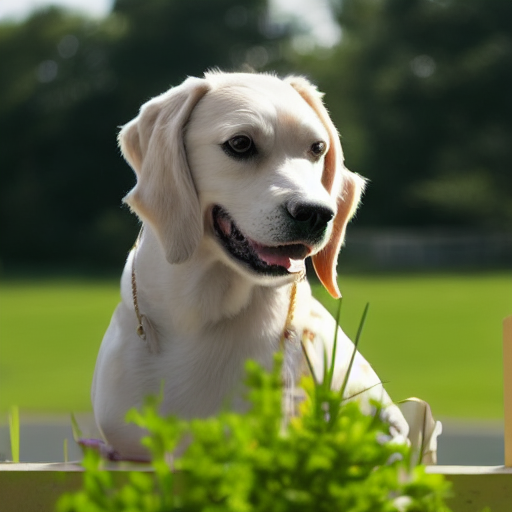

In [17]:
Image.fromarray(output_image)

In [ ]:
%load_ext autoreload
%autoreload 2
    
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
from models.diffusion import StableDiffusion
import torch
from torchvision import transforms
from transformers import CLIPTokenizer
from PIL import Image
from utils.model_converter import load_weights_from_ckpt
from torch.ao.quantization import QConfig, HistogramObserver, MinMaxObserver


cond = [[0, 0, 0, 0, 1]]
uncond = [[0, 0, 0, 0, 0]]   # Also known as negative prompt
do_cfg = True
cfg_scale = 8  # min: 1, max: 14

## IMAGE TO IMAGE

# Comment to disable image to image
input_image = None
image_path = "./images/image_6.JPEG"
input_image = Image.open(image_path)

# Higher values means more noise will be added to the input image, so the result will further from the input image.
# Lower values means less noise is added to the input image, so output will be closer to the input image.
strength = 0.1

## SAMPLER
num_inference_steps = 50
seed = 42
model = StableDiffusion(model_type='class2img', num_classes=5)
loaded_state_dict = torch.load('./weights/model/stable_diffusion_epoch_33.ckpt', map_location='cpu')['model_state_dict']
model.load_state_dict(loaded_state_dict)

In [ ]:
%load_ext autoreload
%autoreload 2

output_image = model.generate_img_from_given_class(
    input_image=None,
    img_size=(16, 16),
    cond=[[0, 0, 0, 0, 0]],
     uncond=[[0, 0, 0, 0, 0]],
     do_cfg=False,
     cfg_scale=cfg_scale,
     device='cpu',
     strength=1.0,
     inference_steps=num_inference_steps,
     sampler='ddpm',
     use_cosine_schedule=False,
     seed=None)

In [ ]:
output_image.resize((128, 128))

In [24]:
%load_ext autoreload
%autoreload 2
!python3 train.py --device=mps --img_size 16 --batch_size 32 --data_dir ./data/sprites/ --save_dir ./checkpoints/ --checkpoint_dir ./checkpoints/

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


python(76808) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 0:  13%|██▍               | 301/2235 [04:44<26:27,  1.22it/s, loss=1.0870]^C
